# (19) MNIST — rsample + MEI — 1

**Motivation**: Poisson VAE, reparameterization. MEI (excite) and MII (inhibit) on latents. No interpretable structure, but some structure. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Import $/$ prep

In [2]:
from _tmp.gapvae import prepare_stuff, iteration, validate
from _tmp.plotters import plot_latent_space, plot_latent_scatter

In [3]:
n_latents = 40
weight_norm = True

batch_size = 300
epochs = 1200

pvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    model='pois',
    device_idx=1,
    n_latents=n_latents,
    weight_norm=weight_norm,
    max_grad_norm=500,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=1.0,
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  7.8 Mil   |
|     ---     |    ---     |
|     enc     |  6.6 Mil   |
|    fc_enc   |   1.3 K    |
|     dec     |  1.2 Mil   |
|    fc_dec   |   42.0 K   |
+-------------+------------+

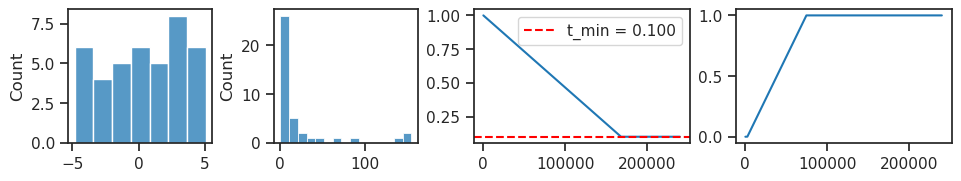

In [4]:
fig, axes = create_figure(1, 4, (9.5, 1.7), width_ratios=[1, 1, 1.5, 1.5], layout='constrained')

sns.histplot(to_np(pvae.log_rates).ravel(), ax=axes[0])
sns.histplot(to_np(pvae.log_rates.exp()).ravel(), ax=axes[1])
axes[2].plot(kws_iter['temperatures'])
axes[3].plot(kws_iter['beta_values'])
_t = kws_iter['temperatures'].min()
axes[2].axhline(_t, color='r', ls='--', label=f't_min = {_t:0.3f}')
axes[2].legend()
plt.show()

## Train / Validate

### trn

In [5]:
%%time

pbar = tqdm(range(epochs), ncols=130, position=0)
nelbo, grads = np.zeros(epochs), np.zeros(epochs)

for ep in pbar:
    grad, tot, recon, kl = iteration(
        ep, pvae, trn, optim, optim_schedule, device, **kws_iter)
    nelbo[ep], grads[ep] = recon + 1.0 * kl, grad

    msg = ',  '.join([
        f"grad = {grad:0.1f}",
        f"loss = (kl: {kl:0.1f}, recon: {recon:0.1f}  ——  tot: {tot:0.2f})  ",
    ])
    pbar.set_description(msg)

grad = 98.1,  loss = (kl: 10.6, recon: 20.1  ——  tot: 30.76)  : 100%|███████████████████████| 1200/1200 [3:28:05<00:00, 10.40s/it]

CPU times: user 5h 21min 44s, sys: 4min 5s, total: 5h 25min 50s
Wall time: 3h 28min 5s


### vld

In [ ]:
emb, labels, loss_vld = validate(pvae, vld, device)
loss_vld

{'kl': 10.734614640778187,
 'recon': 20.419113841337314,
 'tot': 31.15372838637408}

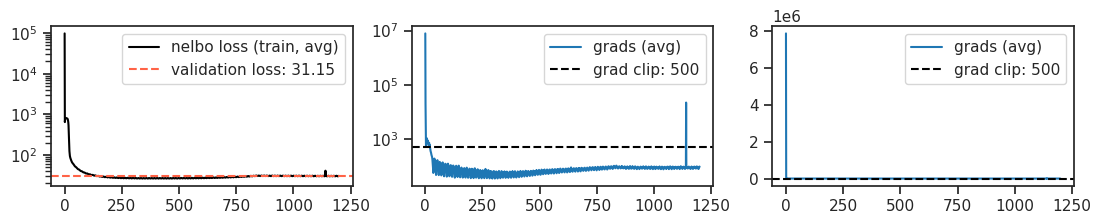

In [ ]:
fig, axes = create_figure(1, 3, (11, 2.4), layout='tight')

axes[0].plot(nelbo, color='k', label='nelbo loss (train, avg)')
axes[0].axhline(loss_vld['tot'], color='tomato', ls='--', label=f"validation loss: {loss_vld['tot']:0.2f}")
axes[0].legend()

for ax in axes[1:].flat:
    ax.plot(grads, label='grads (avg)')
    ax.axhline(kws_iter['max_grad_norm'], color='k', ls='--', label=f"grad clip: {kws_iter['max_grad_norm']}")
    ax.legend()
for i in range(2):
    axes[i].set_yscale('log')
# axes[0].set_ylim(top=50)
plt.show()

In [ ]:
pvae.temp = 0.0

In [ ]:
spks, r_q, r_qp = [], [], []

for x, _ in iter(vld):
    with torch.inference_mode():
        out = pvae(x.to(device))
    spks.append(to_np(out['spks']))
    r_q.append(to_np(out['log_dr'].exp()))
    r_qp.append(to_np(torch.exp(out['log_r'] + out['log_dr'])))

spks, r_q, r_qp = cat_map([spks, r_q, r_qp])
spks = spks.astype(int)

In [ ]:
np.quantile(spks.ravel(), 0.99)

6.0

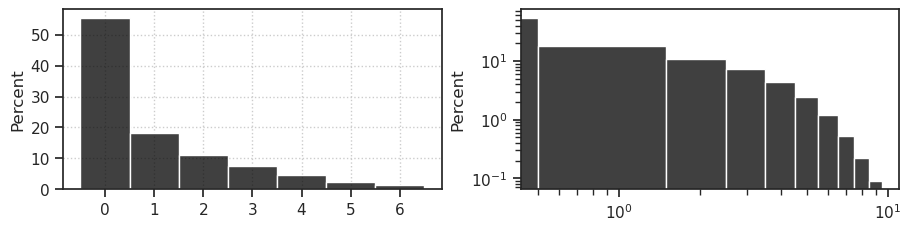

In [ ]:
fig, axes = create_figure(1, 2, (9, 2.2), layout='constrained')

nbins = 7
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[0])
nbins = 10
sns.histplot(spks.ravel(), color='k', stat='percent', bins=np.linspace(0, nbins, nbins+1) - 0.5, ax=axes[1])

axes[0].locator_params(axis='y', nbins=10)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[0].grid()

plt.show()

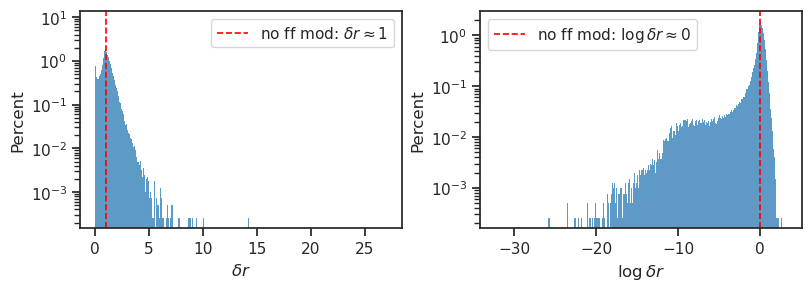

In [ ]:
fig, axes = create_figure(1, 2, (8, 2.8), layout='constrained')

x2p = to_np(r_q).ravel()
for i, ax in enumerate(axes.flat):
    # dr
    sns.histplot(x2p if i == 0 else np.log(x2p), stat='percent', ax=ax)
    # log dr
    lbl = r"$\delta r \approx 1$" if i == 0 else r"$\log \delta r \approx 0$"
    lbl = 'no ff mod: ' + lbl
    ax.axvline(1.0 if i == 0 else 0.0, color='r', ls='--', lw=1.2, label=lbl)
    xlbl = r"$\delta r$" if i == 0 else r"$\log \delta r$"
    ax.set_xlabel(xlbl)
    ax.set_yscale('log')
    ax.legend()

plt.show()

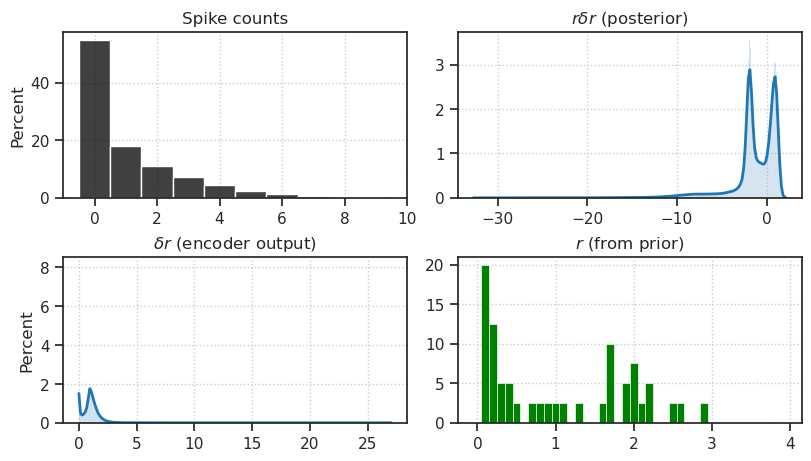

In [ ]:
fig, axes = create_figure(2, 2, (8, 4.5), layout='constrained')

nbins = 10
_kws = dict(
    legend=False, 
    stat='percent',
    bins=np.linspace(0, nbins, nbins+1) - 0.5,
    color='k',
)
sns.histplot(spks.ravel(),  ax=axes[0, 0], **_kws)
# axes[0, 0].locator_params(axis='x', nbins=nbins+2)

_kws = dict(
    kde=True,
    legend=False, 
    stat='percent',
    line_kws={'lw': 2},
    alpha=0.2,
)
sns.histplot(r_q.ravel(), ax=axes[1, 0], **_kws)
sns.histplot(np.log(r_qp.ravel()),  ax=axes[0, 1], **_kws)
_kws.update(dict(kde=False, alpha=1.0, color='g', bins=np.linspace(0, 4, 41) - 0.05))
sns.histplot(to_np(pvae.log_rates.exp()).ravel(), ax=axes[1, 1], **_kws)

axes[0, 0].set_title('Spike counts')
axes[0, 1].set_title(r'$r \delta r$' + ' (posterior)')

axes[1, 0].set_title(r'$\delta r$' + ' (encoder output)')
axes[1, 1].set_title(r'$r$' + ' (from prior)')

# axes[1, 0].set_ylim(top=350)

for ax in axes[:, 1]:
    ax.set_ylabel('')

add_grid(axes)

plt.show()

In [35]:
from torchvision.utils import make_grid

t = 0.0
x_samples = pvae.sample(100, t)

grid_images = make_grid(x_samples, nrow=10, normalize=True, value_range=(0, 1))
grid_images.shape

torch.Size([3, 302, 302])

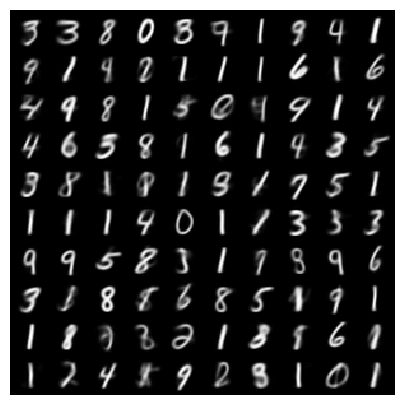

In [36]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (5, 5))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

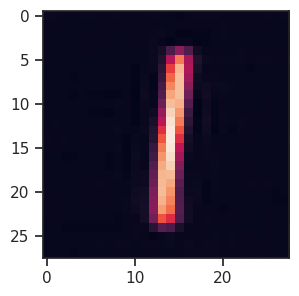

In [37]:
plt.imshow(to_np(x_samples[16].squeeze()));

In [38]:
x, _ = next(iter(vld))
x = x.to(device)
with torch.inference_mode():
    out = pvae(x)

num = 32
grid_images = make_grid(
    torch.cat([x[:num], out['x_recon'][:num]]),
    nrow=num,
    normalize=True,
    value_range=(0, 1),
)

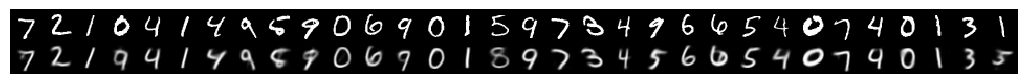

In [39]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (13, 5))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

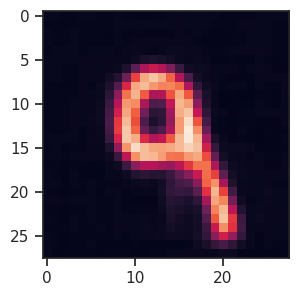

In [40]:
plt.imshow(to_np(out['x_recon'].squeeze()[7]));

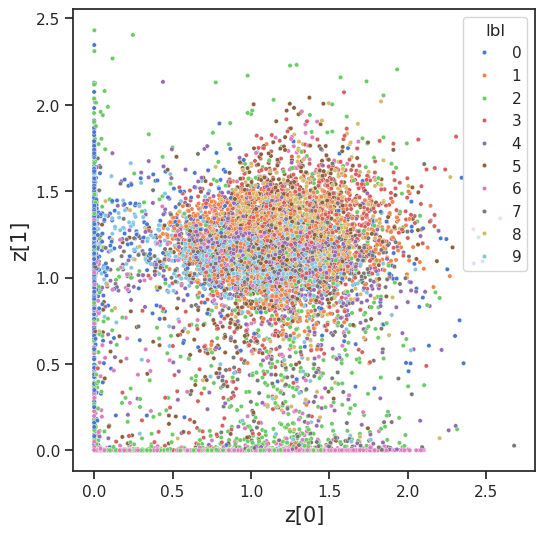

In [41]:
_ = plot_latent_scatter(emb, labels, (0, 2), (6, 6), 10)

In [42]:
uu, ss, vv = sp_lin.svd(emb, full_matrices=False)
ss *= 100 / sum(ss)
ss.shape

(40,)

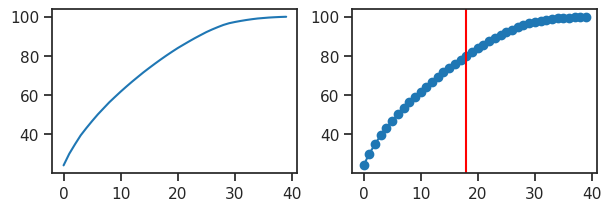

In [43]:
fig, axes = create_figure(1, 2, (6, 2), layout='constrained')
axes[0].plot(np.cumsum(ss))
axes[1].plot(np.cumsum(ss)[:40], marker='o')
axes[1].axvline(18, color='r')
plt.show()
#, marker='o');

## Variability in dr

In [56]:
dr = []
labels = []
for x, y in iter(vld):
    with torch.inference_mode():
        out = pvae(x.to(device))
    dr.append(to_np(out['log_dr'].exp()))
    labels.append(to_np(y))
dr, labels = cat_map([dr, labels])
dr.shape, labels.shape

((10000, 40), (10000,))

In [57]:
means, vars = dr.mean(0), dr.var(0)

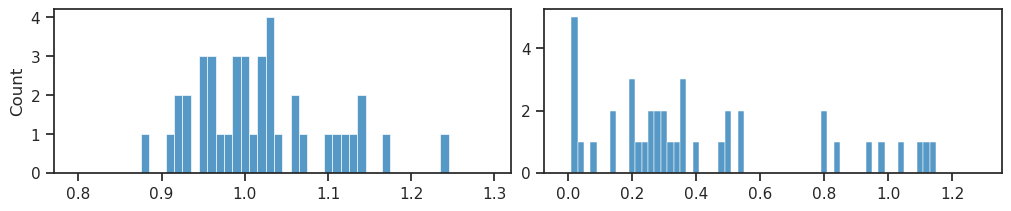

In [86]:
fig, axes = create_figure(1, 2, (10, 2), layout='constrained')
sns.histplot(means, label='means of dr', bins=np.linspace(0.8, 1.3, 51) - 0.005, ax=axes[0])
sns.histplot(vars, label='vars of dr', bins=np.linspace(0.0, 1.3, 66) - 0.01, ax=axes[1])
axes[1].set_ylabel('')
plt.show()

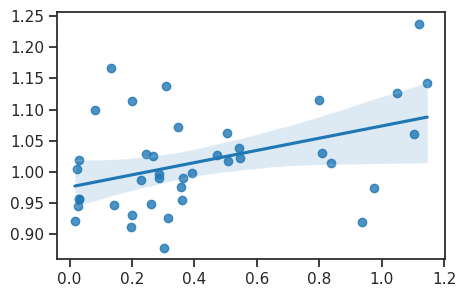

In [89]:
sns.regplot(x=vars, y=means);

In [92]:
latent_i = np.argmax(vars)

latent_i, means[latent_i], vars[latent_i]

(9, 1.1426173, 1.1461551)

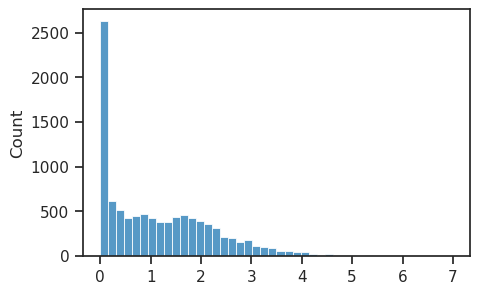

In [94]:
sns.histplot(dr[:, latent_i]);

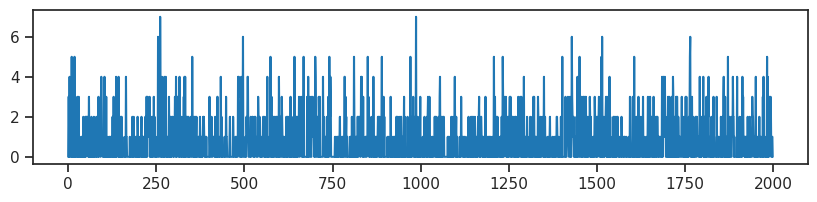

In [119]:
intvl = range(1000, 3000)

fig, ax = create_figure(1, 1, (10, 2))
ax.plot(spks[intvl, latent_i])
plt.show()

### MEI

In [131]:
rng = get_rng()

In [132]:
def compute_mei(model, idx, start, excite=True, alpha=0.1, nsteps=100, scalefunc=lambda x: 1, eps=1e-3, name=''):
    """
        Find an MEI for a given model and neuron ids.

        -model: a pytorch model
        -cids: a list of neuron ids
        -start: the initial input
        -alpha: the learning rate
        -nsteps: the number of steps to run
        -scalefunc: scales the learning rate as a func of step
        -eps: the convergence threshold
        -name: name for printing
    """

    x = start.clone()
    assert len(x) == 1

    pbar = tqdm(range(nsteps))
    for i in pbar:
        model.zero_grad()
        x_copy = x.clone()

        # Get the current prediction
        out = model(x)
        log_dr = out['log_dr'][0, idx]

        if excite:
            y = log_dr
        else:
            y = log_dr.mul(-1)

        # Get the gradient of output with respect to input
        g = torch.autograd.grad(y, x, retain_graph=True)[0]
        g_norm = torch.norm(g)

        if g is None or g_norm == 0:
            print("No gradient at step", i)
            return None

        # Update tqdm description
        msg = f"idx = {idx}  ———  ||g|| = {g_norm:0.5f}"
        pbar.set_description(msg)

        # Update the input
        x = x_copy + scalefunc(i) * alpha * g

        # Terminate if converged
        if torch.abs(x - x_copy).max() < eps:
            print(name, "converged at step", i)
            break

    return x

In [133]:
start = rng.normal(size=(1, 1, 28, 28))
start = torch.nn.Parameter(
    data=torch.tensor(start).float(),
    requires_grad=True,
)
start = start.to(device)

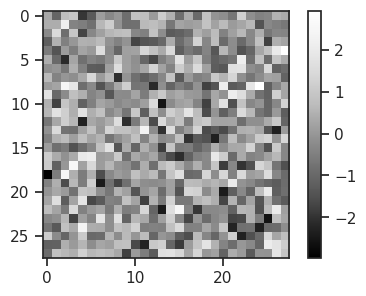

In [134]:
plt.imshow(to_np(start.squeeze()), cmap='Greys_r')
plt.colorbar();

In [135]:
%%time

mei = compute_mei(
    model=pvae,
    idx=latent_i,
    start=start,
    excite=True,
    nsteps=10000,
    alpha=0.1,
)

||g|| = 1.69394: 100%|████████████████████| 10000/10000 [03:03<00:00, 54.43it/s]


CPU times: user 3min 4s, sys: 1.07 s, total: 3min 5s
Wall time: 3min 3s


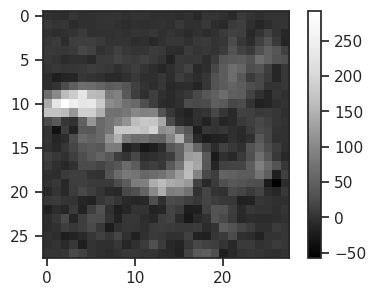

In [139]:
plt.imshow(to_np(mei.squeeze()), cmap='Greys_r')
plt.colorbar();

In [137]:
%%time

mii = compute_mei(
    model=pvae,
    idx=latent_i,
    start=start,
    excite=False,
    nsteps=10000,
    alpha=0.1,
)

||g|| = 2.87492: 100%|████████████████████| 10000/10000 [03:04<00:00, 54.34it/s]

CPU times: user 3min 4s, sys: 1.22 s, total: 3min 6s
Wall time: 3min 4s


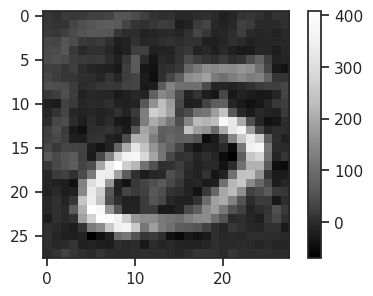

In [140]:
plt.imshow(to_np(mii.squeeze()), cmap='Greys_r')
plt.colorbar();

||g|| = 0.05913:   9%|█▉                   | 1860/20000 [00:32<05:30, 54.82it/s]

converged at step 1863

||g|| = 0.05913:   9%|█▉                   | 1863/20000 [00:32<05:19, 56.73it/s]
||g|| = 1.41800: 100%|████████████████████| 20000/20000 [05:58<00:00, 55.72it/s]


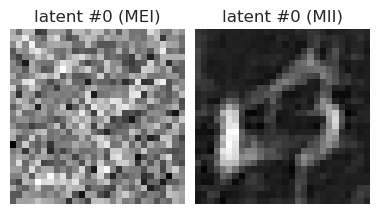

||g|| = 3.51719: 100%|████████████████████| 20000/20000 [06:05<00:00, 54.68it/s]


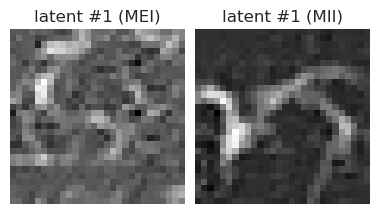

||g|| = 1.33163: 100%|████████████████████| 20000/20000 [06:02<00:00, 55.10it/s]
||g|| = 0.84509: 100%|████████████████████| 20000/20000 [06:05<00:00, 54.76it/s]


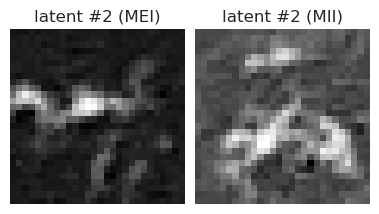

||g|| = 0.36869: 100%|████████████████████| 20000/20000 [06:09<00:00, 54.07it/s]
||g|| = 1.07192:   1%|▎                     | 269/20000 [00:05<06:33, 50.17it/s]

In [ ]:
%%time

mei_all = []
mii_all = []

kws = dict(
    model=pvae,
    idx=idx,
    start=start,
    nsteps=20000,
    alpha=0.1,
)
for idx in range(n_latents):
    mei = compute_mei(excite=True, **kws)
    mii = compute_mei(excite=False, **kws)
    mei_all.append(mei)
    mii_all.append(mii)

    fig, axes = create_figure(1, 2, (3.7, 2), 'all', 'all', layout='constrained')
    axes[0].imshow(to_np(mei.squeeze()), cmap='Greys_r')
    axes[1].imshow(to_np(mii.squeeze()), cmap='Greys_r')
    axes[0].set_title(f'latent #{idx} (MEI)')
    axes[1].set_title(f'latent #{idx} (MII)')
    remove_ticks(axes)
    plt.show()

In [163]:
mei_all = torch.cat(mei_all).squeeze()
mii_all = torch.cat(mii_all).squeeze()
mei_all.shape, mii_all.shape

(torch.Size([40, 28, 28]), torch.Size([40, 28, 28]))

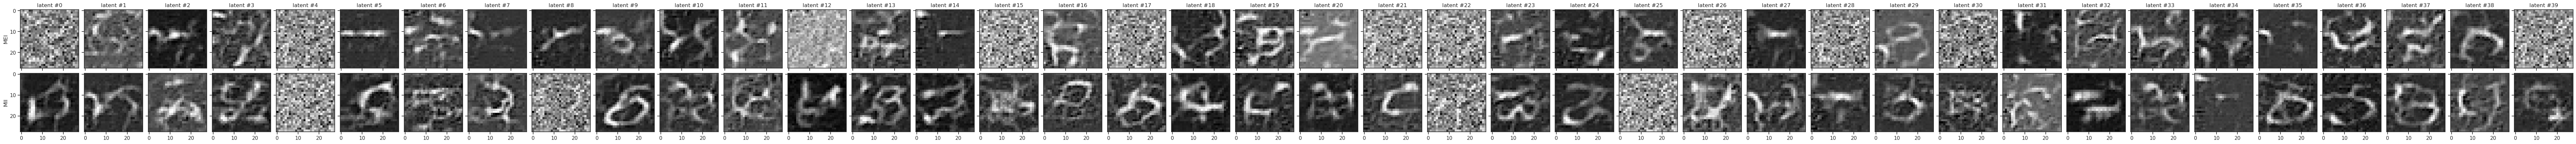

In [171]:
fig, axes = create_figure(2, n_latents, (2 * n_latents, 4.3), 'all', 'all', layout='constrained')

for i in range(n_latents):
    axes[0, i].set_title(f'latent #{i}')
    axes[0, i].imshow(to_np(mei_all[i]), cmap='Greys_r')
    axes[1, i].imshow(to_np(mii_all[i]), cmap='Greys_r')

axes[0, 0].set_ylabel('MEI')
axes[1, 0].set_ylabel('MII')

plt.show()